In [2]:
import os
import json
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image, ImageDraw

DATA_ROOT = "/thiends/hdd2t/UniverSeg/US_map4"
ANNOT_PATH = "/thiends/hdd2t/UniverSeg/mapping_normalized4.jsonl"
RESIZE_TO = (128, 128)

def polygon_to_mask(points, image_size, resize_to=RESIZE_TO):
    mask = Image.new('L', image_size, 0)
    # Chỉ vẽ nếu có ít nhất 3 điểm
    if points is not None and len(points) >= 3:
        ImageDraw.Draw(mask).polygon(points, outline=1, fill=1)
    mask = mask.resize(resize_to, Image.NEAREST)
    mask = np.array(mask).astype(np.float32)
    return mask

def process_image(image_path, resize_to=RESIZE_TO):
    img = Image.open(image_path).convert("RGB")
    img = img.resize(resize_to, Image.BILINEAR)
    img = np.array(img).astype(np.float32) / 255.0
    img = np.transpose(img, (2, 0, 1))
    return img

class OVatusDataset(Dataset):
    def __init__(self, annot_path=ANNOT_PATH, data_root=DATA_ROOT, resize_to=RESIZE_TO):
        self.samples = []
        empty_anno_count = 0
        print("Loading OVatusDataset...")
        with open(annot_path, "r", encoding="utf-8") as f:
            for line_idx, line in enumerate(f, 1):
                item = json.loads(line)
                patient = item["patient_name"]
                for img_info in item["images"]:
                    img_name = img_info["image_name"]
                    img_path = os.path.join(data_root, patient, img_name)
                    image_size = (img_info["imageWidth"], img_info["imageHeight"])
                    img = process_image(img_path, resize_to)
                    masks = []
                    for label_idx, points_list in enumerate(img_info["points"]):
                        if not points_list or len(points_list) < 3:
                            empty_anno_count += 1
                            print(f"  [EMPTY] Line {line_idx}, Patient: {patient}, Image: {img_name}, Label {label_idx}: {points_list}")
                        points = [tuple(map(float, pt)) for pt in points_list] if points_list else []
                        mask = polygon_to_mask(points, image_size, resize_to)
                        masks.append(mask)
                    masks = np.stack(masks)  # [num_labels, H, W]
                    self.samples.append((img, masks, img_path))
        print(f"Loaded {len(self.samples)} images")
        print(f"Total empty annotations: {empty_anno_count}")
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        img, masks, img_path = self.samples[idx]
        img = torch.from_numpy(img).float()
        masks = torch.from_numpy(masks).float()
        return img, masks, img_path

In [3]:
# split_dataset.py
import numpy as np
import os
from torch.utils.data import Dataset, Subset
from typing import Tuple

def patient_level_split_60_20_20(
    dataset: Dataset,
    seed: int = 42
) -> Tuple[Subset, Subset, Subset]:
    """
    Chia theo subject (patient) đúng như paper UniverSeg:
    - 60% support pool → dùng để sample support set động
    - 20% dev → không dùng ở đây (có thể dùng để tune)
    - 20% test → báo cáo cuối cùng
    """
    patient_to_indices = {}
    print("[DEBUG] Bắt đầu duyệt dataset để gom index theo bệnh nhân...")
    for idx in range(len(dataset)):
        _, _, img_path = dataset[idx]
        patient = os.path.basename(os.path.dirname(img_path))
        patient_to_indices.setdefault(patient, []).append(idx)
        print(f"[DEBUG] idx={idx}, img_path={img_path}, patient={patient}")

    patients = list(patient_to_indices.keys())
    print(f"[DEBUG] Danh sách bệnh nhân: {patients}")
    rng = np.random.default_rng(seed)
    rng.shuffle(patients)
    print(f"[DEBUG] Danh sách bệnh nhân sau khi shuffle: {patients}")

    n = len(patients)
    n_support = int(0.6 * n)
    n_dev = int(0.2 * n)
    print(f"[DEBUG] Tổng số bệnh nhân: {n}, n_support={n_support}, n_dev={n_dev}")

    support_patients = patients[:n_support]
    dev_patients = patients[n_support:n_support + n_dev]
    test_patients = patients[n_support + n_dev:]
    print(f"[DEBUG] support_patients={support_patients}")
    print(f"[DEBUG] dev_patients={dev_patients}")
    print(f"[DEBUG] test_patients={test_patients}")

    def get_idxs(p_list):
        idxs = [i for p in p_list for i in patient_to_indices[p]]
        print(f"[DEBUG] get_idxs({p_list}) -> {idxs}")
        return idxs

    support_idxs = get_idxs(support_patients)
    dev_idxs = get_idxs(dev_patients)
    test_idxs = get_idxs(test_patients)

    print(f"Total patients: {len(patients)}")
    print(f"Support pool : {len(support_patients)} patients → {len(support_idxs)} images")
    print(f"Dev set      : {len(dev_patients)} patients → {len(dev_idxs)} images")
    print(f"Test set     : {len(test_patients)} patients → {len(test_idxs)} images")

    return Subset(dataset, support_idxs), Subset(dataset, dev_idxs), Subset(dataset, test_idxs)

In [4]:
# Visualization helper function (dùng để visualize multiple samples)
import matplotlib.pyplot as plt
import math

def visualize_samples(samples_data, col_wrap=4, title=None):
    """
    Visualize samples từ dataset
    samples_data: dict with keys như 'Images', 'Masks' và values là list of tensors
    """
    groups = list(samples_data.keys())
    num_samples = len(next(iter(samples_data.values())))
    
    cols = col_wrap
    rows = math.ceil(num_samples / cols) * len(groups)
    
    fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    for g, (group_name, tensors) in enumerate(samples_data.items()):
        for k, tensor in enumerate(tensors):
            col = k % cols
            row = g + len(groups) * (k // cols)
            
            # Convert tensor to numpy and squeeze
            x = tensor.detach().cpu().numpy().squeeze()
            ax = axes[row, col]
            
            # Display based on dimensions
            if len(x.shape) == 2:  # Grayscale (H, W)
                ax.imshow(x, vmin=0, vmax=1, cmap='gray')
            elif len(x.shape) == 3:  # RGB (C, H, W) or (H, W, C)
                if x.shape[0] == 3:  # CHW format
                    x = x.transpose(1, 2, 0)
                ax.imshow(x)
            
            if col == 0:
                ax.set_ylabel(group_name, fontsize=12, fontweight='bold')
            
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])
    
    if title:
        plt.suptitle(title, fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

Loading OVatusDataset...
  [EMPTY] Line 32, Patient: 252_2300070396_ĐÀM BẠCH NHẠN, Image: 21.7_0002.JPG, Label 1: [[703.6814159292036, 177.8761061946903], [706.3362831858407, 176.9911504424779]]
  [EMPTY] Line 32, Patient: 252_2300070396_ĐÀM BẠCH NHẠN, Image: 21.7_0002.JPG, Label 2: [[461.2035398230089, 338.05309734513276]]
  [EMPTY] Line 32, Patient: 252_2300070396_ĐÀM BẠCH NHẠN, Image: 21.7_0003.JPG, Label 1: [[762.0884955752213, 324.7787610619469]]
Loaded 583 images
Total empty annotations: 3


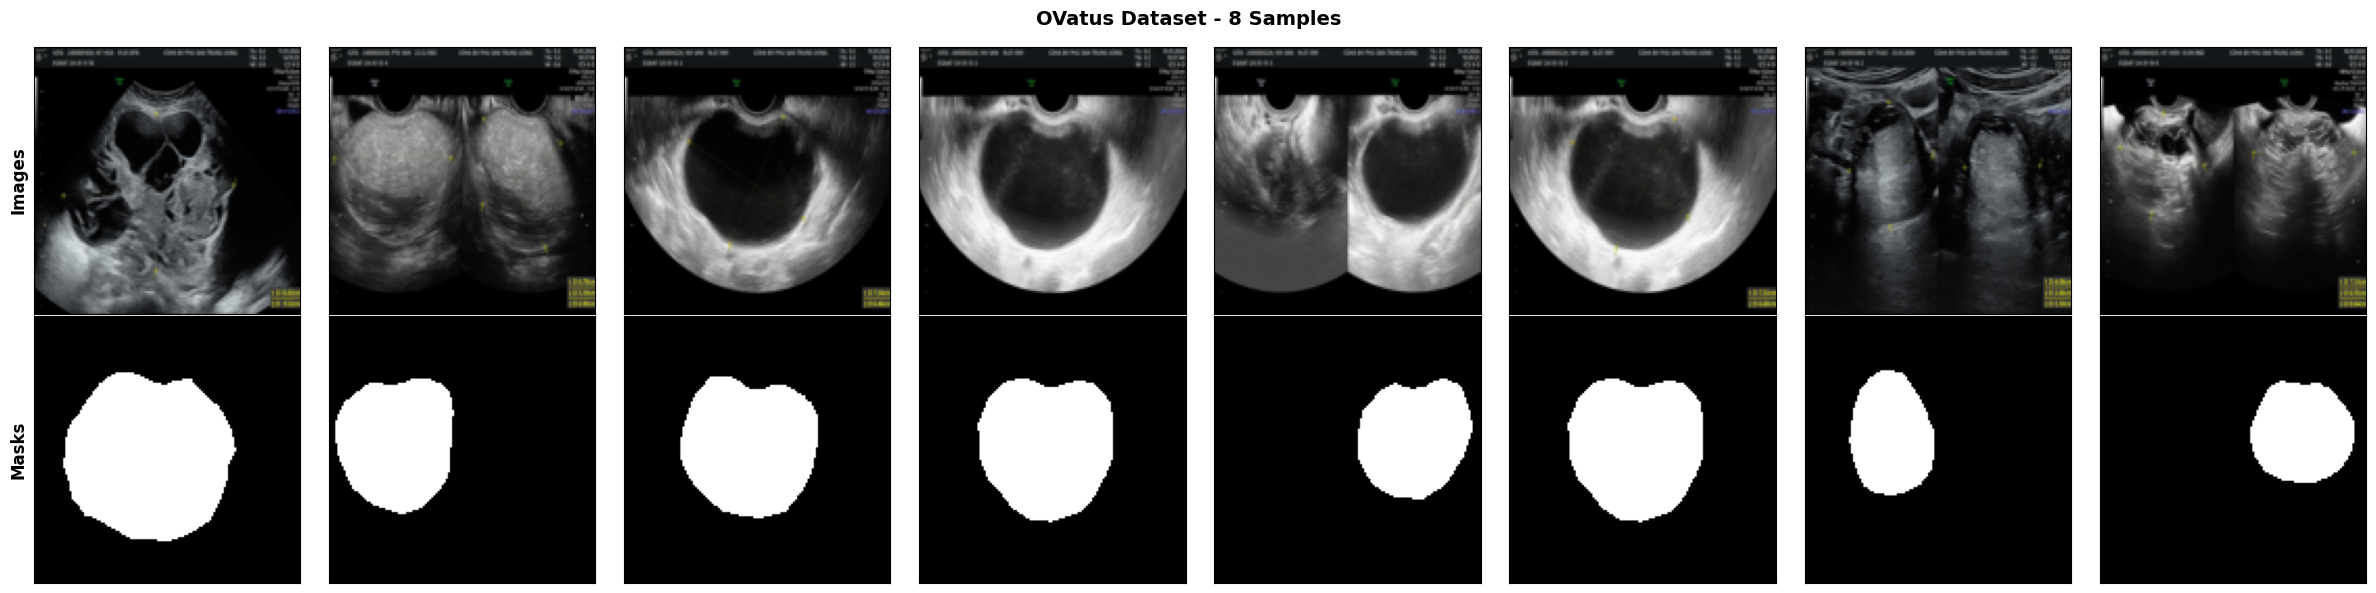

In [5]:
# Initialize dataset và visualize một số samples
dataset = OVatusDataset()

# Lấy 8 samples đầu tiên
num_samples_to_show = 8
sample_images = []
sample_masks = []

for i in range(min(num_samples_to_show, len(dataset))):
    img, masks, _ = dataset[i]
    sample_images.append(img)
    # Stack all masks for this sample
    sample_masks.append(masks[0])  # Lấy mask đầu tiên từ mỗi sample

# Visualize
visualize_samples({
    'Images': sample_images,
    'Masks': sample_masks,
}, col_wrap=8, title=f'OVatus Dataset - {num_samples_to_show} Samples')

[DEBUG] Bắt đầu duyệt dataset để gom index theo bệnh nhân...
[DEBUG] idx=0, img_path=/thiends/hdd2t/UniverSeg/US_map4/167_Nguyễn Thị Hoa/b7547ff0-1c01-42c3-bc54-5946129319cf.jpg, patient=167_Nguyễn Thị Hoa
[DEBUG] idx=1, img_path=/thiends/hdd2t/UniverSeg/US_map4/168_Phạm Thị Khánh Vân/b15cfe36-db12-4214-ba54-4d23bf4bada0.jpg, patient=168_Phạm Thị Khánh Vân
[DEBUG] idx=2, img_path=/thiends/hdd2t/UniverSeg/US_map4/169_2400004224_NH VAN/30357e2b-f9ad-4d0d-816b-9c2441fed95b.jpg, patient=169_2400004224_NH VAN
[DEBUG] idx=3, img_path=/thiends/hdd2t/UniverSeg/US_map4/169_2400004224_NH VAN/3ca86db1-9940-4b5c-86f2-de564316180d.jpg, patient=169_2400004224_NH VAN
[DEBUG] idx=4, img_path=/thiends/hdd2t/UniverSeg/US_map4/169_2400004224_NH VAN/75bfbf08-3339-441b-a9ee-b290d2d346e4.jpg, patient=169_2400004224_NH VAN
[DEBUG] idx=5, img_path=/thiends/hdd2t/UniverSeg/US_map4/169_2400004224_NH VAN/9fcf5d33-dba4-4f7e-ac62-a2128ccfa895.jpg, patient=169_2400004224_NH VAN
[DEBUG] idx=6, img_path=/thiends/hdd2

[DEBUG] Bắt đầu duyệt dataset để gom index theo bệnh nhân...
[DEBUG] idx=0, img_path=/thiends/hdd2t/UniverSeg/US_map4/167_Nguyễn Thị Hoa/b7547ff0-1c01-42c3-bc54-5946129319cf.jpg, patient=167_Nguyễn Thị Hoa
[DEBUG] idx=1, img_path=/thiends/hdd2t/UniverSeg/US_map4/168_Phạm Thị Khánh Vân/b15cfe36-db12-4214-ba54-4d23bf4bada0.jpg, patient=168_Phạm Thị Khánh Vân
[DEBUG] idx=2, img_path=/thiends/hdd2t/UniverSeg/US_map4/169_2400004224_NH VAN/30357e2b-f9ad-4d0d-816b-9c2441fed95b.jpg, patient=169_2400004224_NH VAN
[DEBUG] idx=3, img_path=/thiends/hdd2t/UniverSeg/US_map4/169_2400004224_NH VAN/3ca86db1-9940-4b5c-86f2-de564316180d.jpg, patient=169_2400004224_NH VAN
[DEBUG] idx=4, img_path=/thiends/hdd2t/UniverSeg/US_map4/169_2400004224_NH VAN/75bfbf08-3339-441b-a9ee-b290d2d346e4.jpg, patient=169_2400004224_NH VAN
[DEBUG] idx=5, img_path=/thiends/hdd2t/UniverSeg/US_map4/169_2400004224_NH VAN/9fcf5d33-dba4-4f7e-ac62-a2128ccfa895.jpg, patient=169_2400004224_NH VAN
[DEBUG] idx=6, img_path=/thiends/hdd2

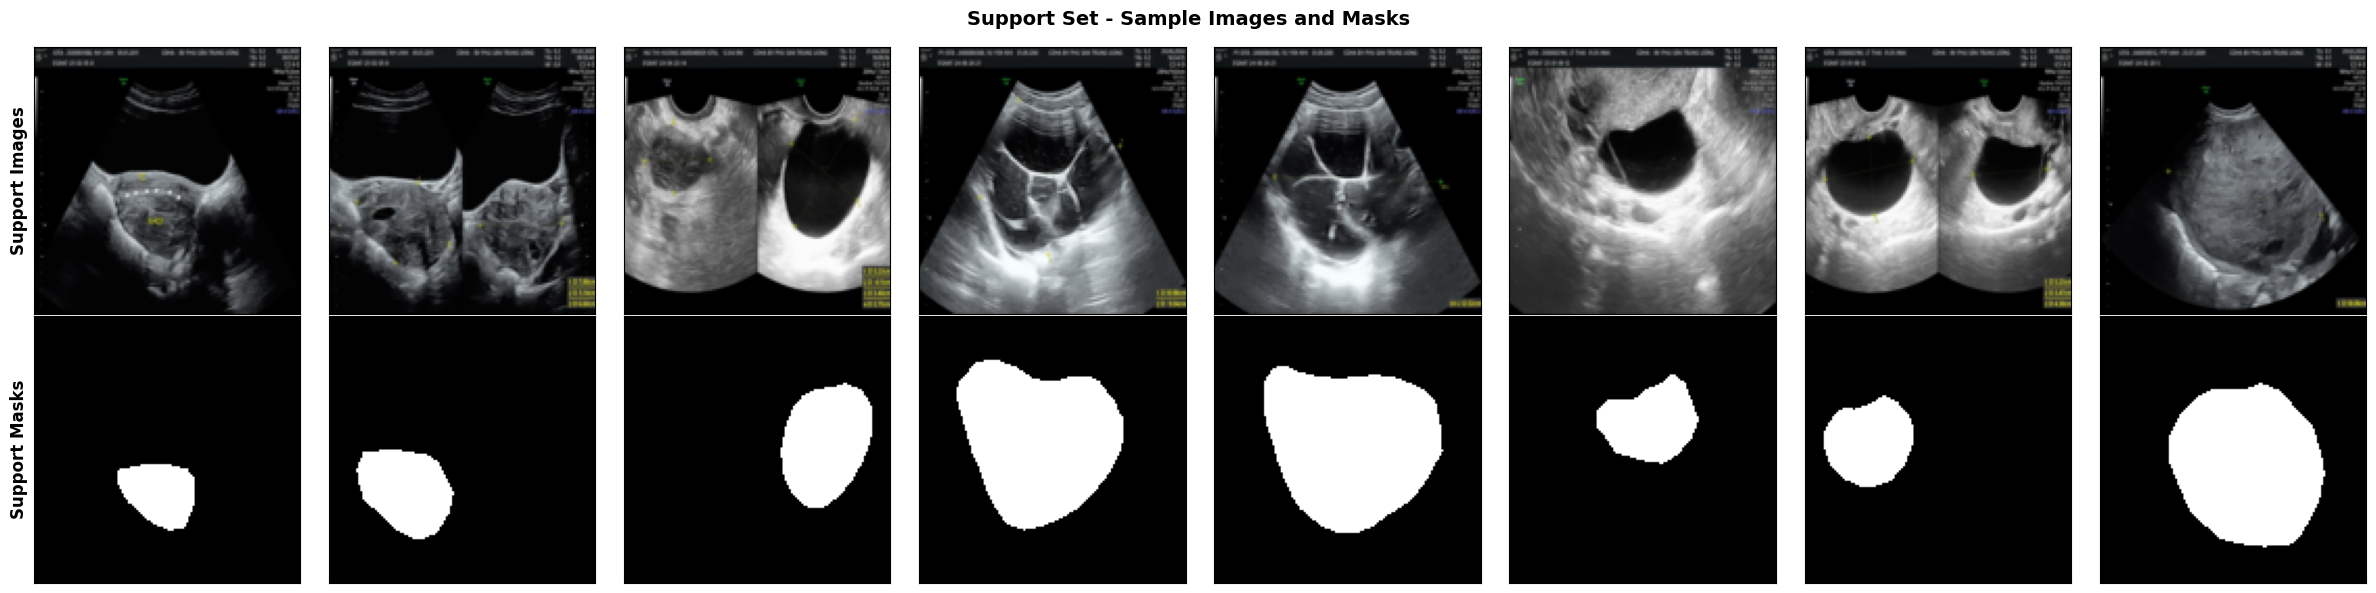

In [6]:
# Split dataset into support, dev, and test sets
support_subset, dev_subset, test_subset = patient_level_split_60_20_20(dataset)

print(f"\nDataset splits:")
print(f"Support set: {len(support_subset)} images")
print(f"Dev set: {len(dev_subset)} images")
print(f"Test set: {len(test_subset)} images")

# Visualize 8 support samples
support_sample_images = []
support_sample_masks = []

for i in range(min(8, len(support_subset))):
    img, masks, _ = support_subset[i]
    support_sample_images.append(img)
    support_sample_masks.append(masks[0])

visualize_samples({
    'Support Images': support_sample_images,
    'Support Masks': support_sample_masks,
}, col_wrap=8, title='Support Set - Sample Images and Masks')